In [2]:
# # function prototype

# # raw image --> aligned to day 1 --> cropped image --> normalized?

# preprocessed_image = compute_preproccessed_image(raw_image, align_reference_day)

# # get region given preprocessed image

# class Region(Enum):
#     GRASS = 0;
#     SIDEWALK = 1;
#     BUILDING = 2;
#     TREE = 3;
#     OTHER = 4;


# region = get_region(preprocessed_image, Region.GRASS)

# class MovingObjects(Enum):
#     VEHICLE = 1;
#     PERSON = 2;
#     BIKE =3;

# [location, new_old/status] = object_detection(preprocessed_image, MovingObjects.VEHICLE)

# report = create_report(list_of_all_detections_and_anamolies, _day_number)

# Setup

### Debugging

In [194]:
DEBUG = True
INFO = True
PLOT = True

In [184]:
def debug(s):
    if DEBUG:
        print(s)

In [185]:
def info(s, *args):
    if INFO:
        print(s)

### Imports

In [234]:
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter
from skimage.morphology import area_opening, disk, diameter_opening
from sklearn.cluster import KMeans

### Helper Functions

In [187]:
# put [] around single image

def plot_images(image_list, title_list=[], grid='off'):
    if PLOT:
        fig, axes = plt.subplots(nrows=1, ncols=len(image_list), figsize=(10*len(image_list), 10*1))
        if len(image_list) == 1:
            axes = [axes]

        for i, ax in enumerate(axes):
            ax.imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))
            if len(title_list) > 0:
                ax.set_title(title_list[i])
            ax.axis(grid)

### Data

In [221]:
NUM_CLUSTERS = 10
IMAGE_TYPE = 'BGR' #'HSV'
CLUSTER_TYPE = 'CLUSTER' # 'SMOOTH'

In [1]:
# select global image to read in from Missions folder
global_image = cv2.imread('..\\Missions\\mission_2_composite_FINAL.tiff')
print('global_image.shape:', global_image.shape)

# resize so easier computation
global_image_with_borders = cv2.resize(global_image, (0,0), fx=0.1, fy=0.1)
print('global_image_with_borders.shape:', global_image_with_borders.shape)

# remove black borders
# TODO automate this because 10px may not ben enough for different sizes, may be fine if roughly same resolution
h, w, c = global_image_with_borders.shape
global_image_without_borders = copy.deepcopy(global_image_with_borders)[10:h-10, 10:w-10, :].astype(np.uint8)
print('global_image_without_borders.shape:', global_image_without_borders.shape)

NameError: name 'cv2' is not defined

In [8]:
# # automate the border removing process

# import imutils


# mask = (1-np.all(image_w_borders == 0, axis=(2)))*255
# mask = mask.astype(np.uint8)

# plot_images([mask], ['mask'])


# # Finds contours from the binary image
# contours = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# contours = imutils.grab_contours(contours)

# # get the maximum contour area
# c = max(contours, key=cv2.contourArea)

# # get a bbox from the contour area
# (x, y, w, h) = cv2.boundingRect(c)
# print(x, y, w, h)

# # crop the image to the bbox coordinates
# # result = result[y:y + h, x:x + w]
# plot_images([image_w_borders[y:y + h, x:x + w]])

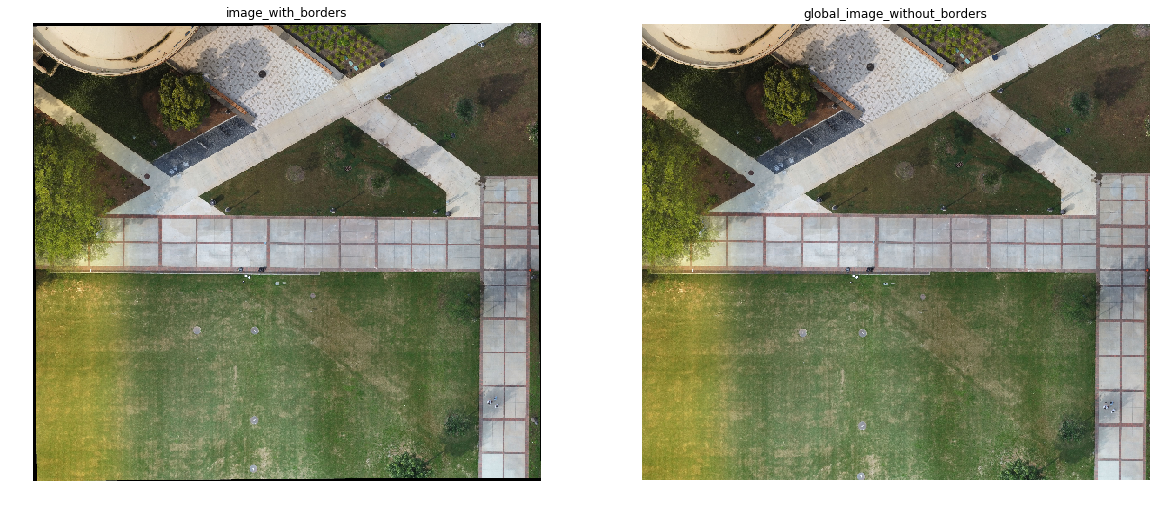

In [217]:
plot_images([global_image_with_borders, global_image_without_borders], ['image_with_borders', 'global_image_without_borders'])

In [219]:
image_bgr = copy.deepcopy(global_image_without_borders)
image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

HEIGHT, WIDTH, CHANNELS = image_bgr.shape
print('image.shape:', image_bgr.shape)

image.shape: (507, 564, 3)


# Clustering

In [203]:
def compute_clusters(image):
    X = np.reshape(image, [-1, CHANNELS]).astype(np.float32)
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(X)
    
    cluster_centers = kmeans.cluster_centers_.astype(int)
    
    clustered_image = np.reshape(cluster_centers[kmeans.labels_], (HEIGHT, WIDTH, CHANNELS)).astype(np.uint8)
    
    smooth_image = cv2.medianBlur(clustered_image, 5).astype(np.uint8)

    return clustered_image, smooth_image, cluster_centers

### BGR - Cluster, Smooth

In [204]:
clustered_image_bgr, smooth_image_bgr, cluster_centers_bgr = compute_clusters(image_bgr)

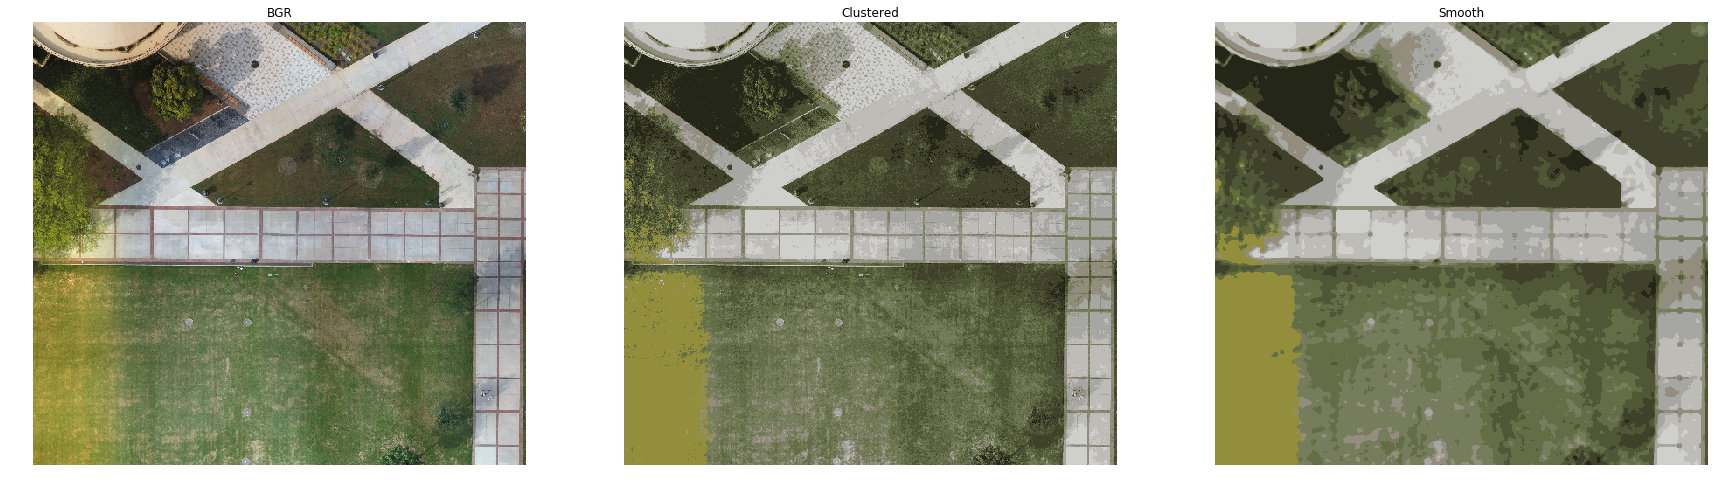

In [205]:
image_list = [image_bgr, clustered_image_bgr, smooth_image_bgr]
title_list = ['BGR', 'Clustered', 'Smooth']
plot_images(image_list, title_list)

## HSV - Cluster, Smooth

In [207]:
clustered_image_hsv, smooth_image_hsv, cluster_centers_hsv = compute_clusters(image_hsv)

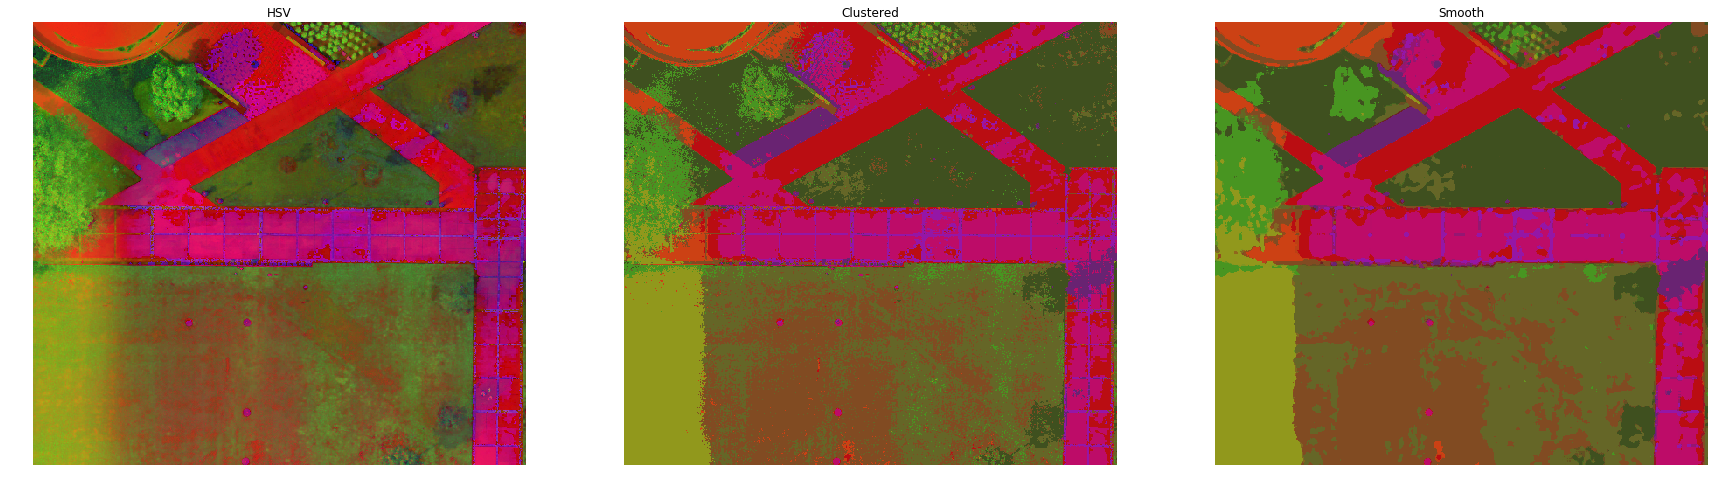

In [208]:
image_list = [image_hsv, clustered_image_hsv, smooth_image_hsv]
title_list = ['HSV', 'Clustered', 'Smooth']
plot_images(image_list, title_list)

### BGR - Channels

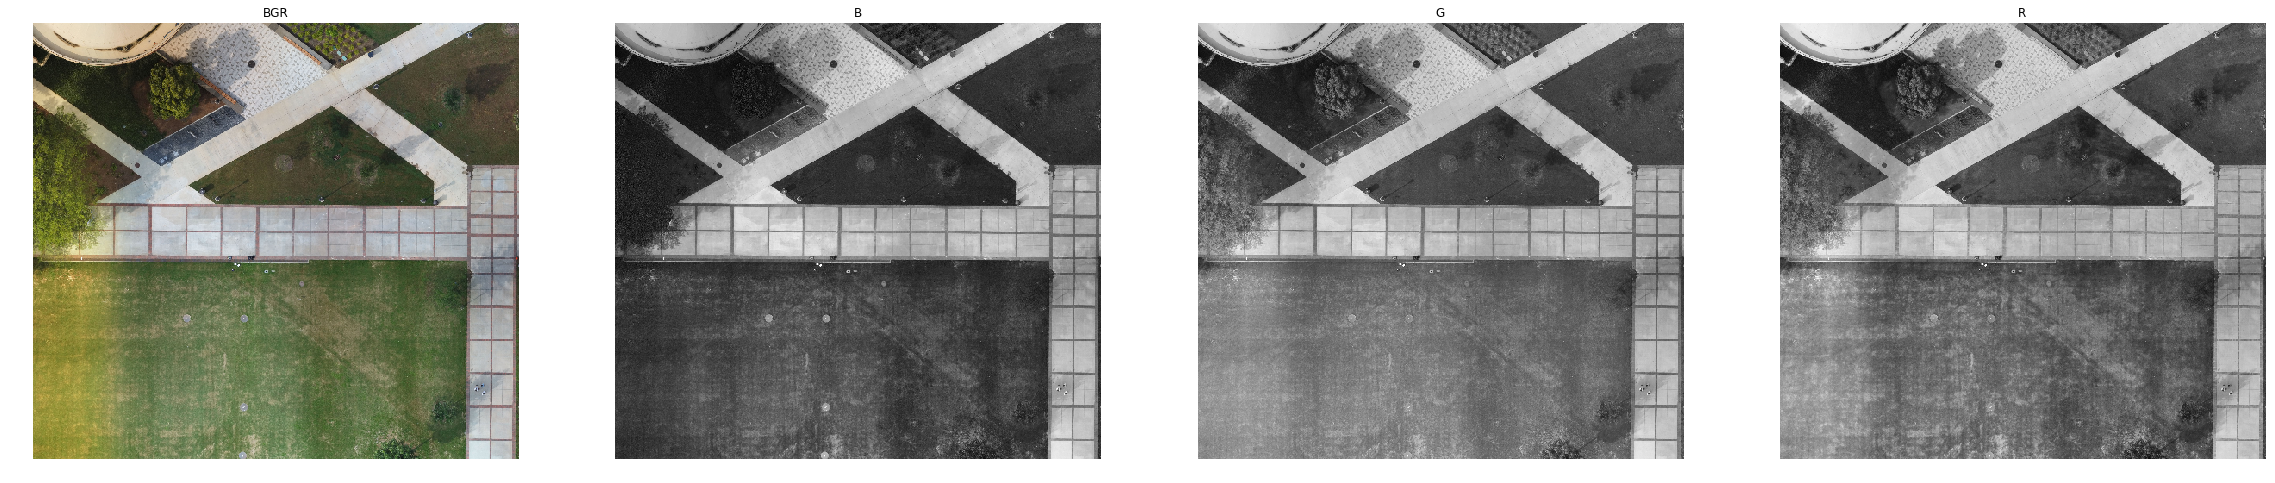

In [209]:
plot_images([image_bgr, image_bgr[:, :, 0], image_bgr[:, :, 1], image_bgr[:, :, 2]], ['BGR', 'B', 'G', 'R'])

### HSV - Channels

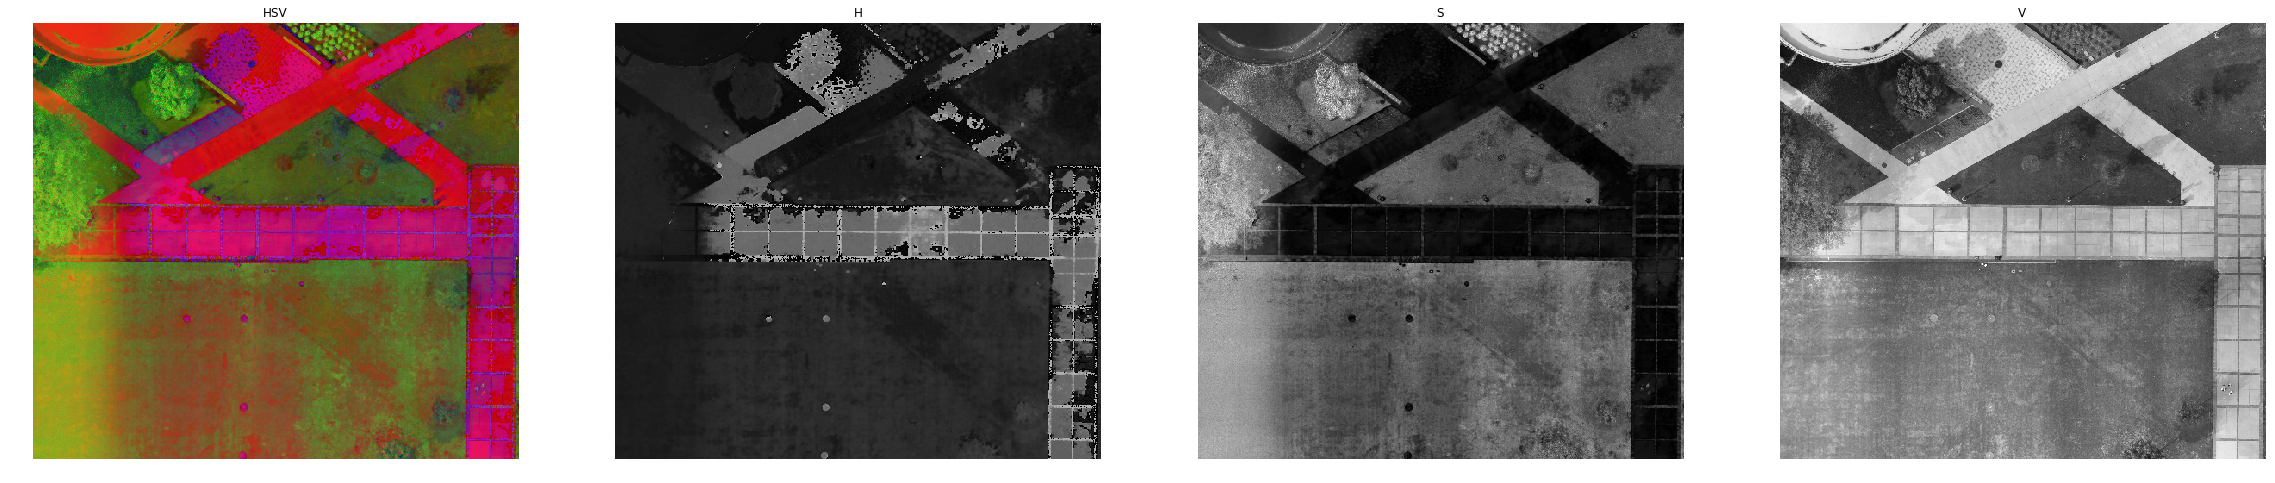

In [210]:
plot_images([image_hsv, image_hsv[:, :, 0], image_hsv[:, :, 1], image_hsv[:, :, 2]], ['HSV', 'H', 'S', 'V'])

# Segmentation

In [223]:
if IMAGE_TYPE == 'BGR':
    IMAGE = copy.deepcopy(smooth_image_bgr)
    IMAGE_clusters_centers = copy.deepcopy(cluster_centers_bgr)
elif IMAGE_TYPE == 'HSV':
    IMAGE = copy.deepcopy(smooth_image_hsv)
    IMAGE_clusters_centers = copy.deepcopy(cluster_centers_hsv)
else:
    print('invalid image type selected')

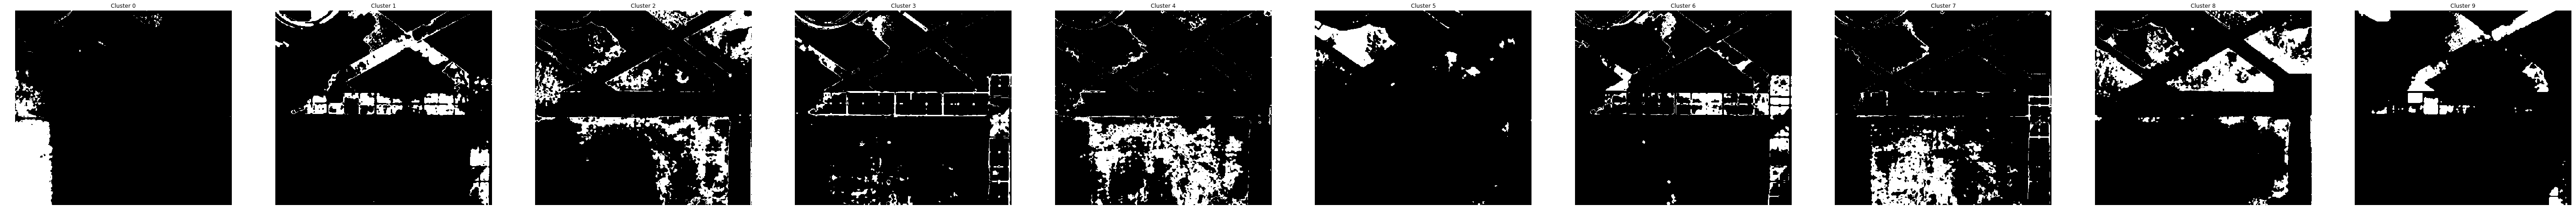

In [225]:
# break apart image into NUM_CLUSTERS individual clusters

clusters = []
for i in range(0, NUM_CLUSTERS):
    mask = IMAGE == IMAGE_clusters_centers[i]
    mask = mask.astype(np.uint8)*255
    clusters.append(mask[:, :, 0]) # 3 channels are just copies

plot_images(clusters, ['Cluster '+str(i) for i in range(0, NUM_CLUSTERS)])

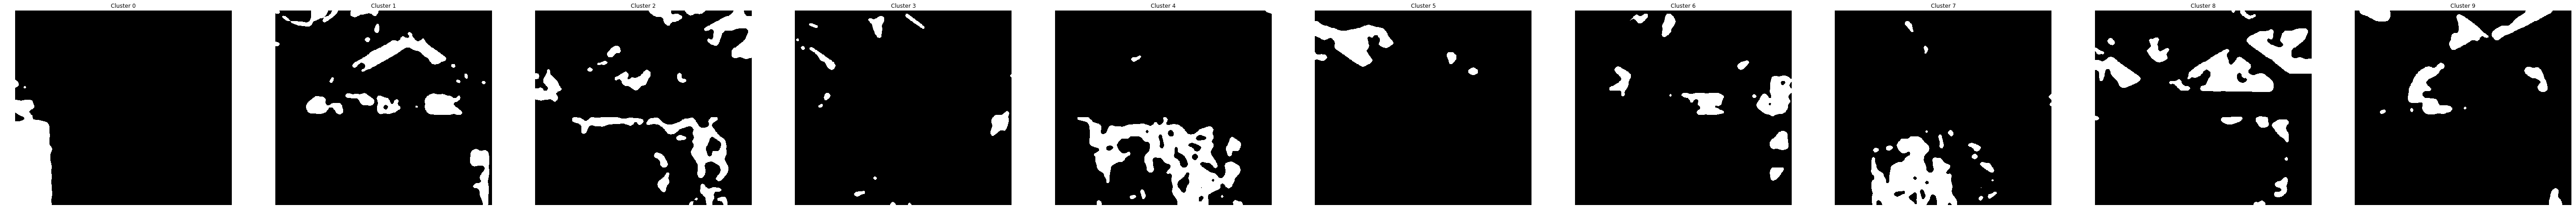

In [237]:
# apply mode filter to remove stray pixels

NUM_MODE = 3
RADIUS_MODE = 10

moded_clusters = []
for i in range(0, NUM_CLUSTERS):
    moded_cluster = Image.fromarray(clusters[i])
    for j in range(0, NUM_MODE):
        moded_cluster = moded_cluster.filter(ImageFilter.ModeFilter(RADIUS_MODE))
    moded_clusters.append(np.array(moded_cluster).astype(np.uint8))

plot_images(moded_clusters, ['Cluster '+str(i) for i in range(0, NUM_CLUSTERS)])

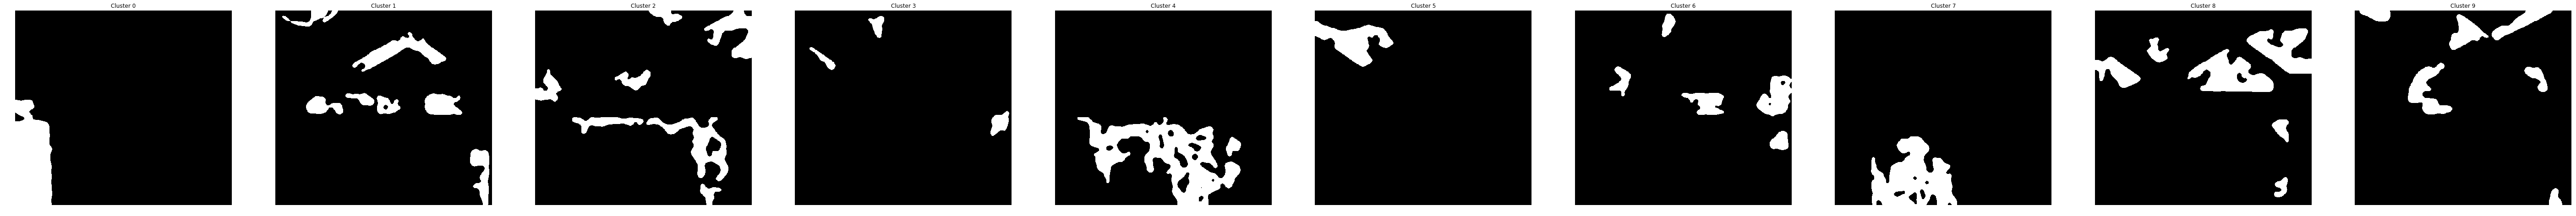

In [252]:
# morphology open to remove small white patches
# Area opening removes all bright structures of an image with a surface smaller than area_threshold.
# The output image is thus the largest image smaller than the input for which all local maxima have at least a surface of area_threshold pixels.

opened_clusters = []
for i in range(0, NUM_CLUSTERS):
    opened_cluster = area_opening(image=moded_clusters[i], area_threshold=1000)
    opened_clusters.append(opened_cluster)
    
plot_images(opened_clusters, ['Cluster '+str(i) for i in range(0, NUM_CLUSTERS+1)])

In [260]:
# # morphology open to remove small white patches
# # Area opening removes all bright structures of an image with a surface smaller than area_threshold.
# # The output image is thus the largest image smaller than the input for which all local maxima have at least a surface of area_threshold pixels.

# opened_clusters = []
# for i in range(0, NUM_CLUSTERS):
# #     eroded_region = cv2.erode(moded_regions[i], disk(radius=4), iterations=1)
#     opened_cluster = cv2.area_opening(image=moded_clusters[i], area_threshold=100)
#     opened_clusters.append(eroded_cluster)
    
# plot_images(opened_clusters, ['Cluster '+str(i) for i in range(0, NUM_CLUSTERS)])

In [261]:
# # expand back a littel so borders are smaller later

# dilated_regions = []
# for i in range(0, NUM_CLUSTERS):
#     dilated_region = cv2.dilate(eroded_regions[i], disk(radius=2), iterations=2)
#     dilated_regions.append(dilated_region)
    
# # correct region is white
# image_list = dilated_regions
# title_list = ['Region '+str(i) for i in range(0, NUM_CLUSTERS)]
# plot_images(image_list, title_list)

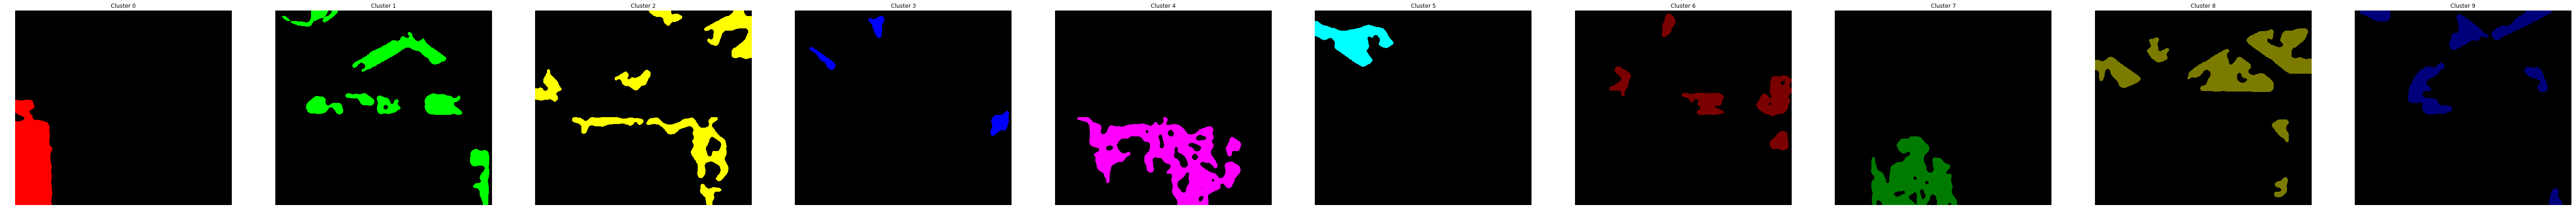

In [253]:
# now put together, since dilate was down and regions shrunk there should be "natural" borders between the regions

colors = [[0, 0, 255], [0, 255, 0], [0, 255, 255], [255, 0, 0], [255, 0, 255], [255, 255, 0], [0, 0, 123], [0, 123, 0], [0, 123, 123], [123, 0, 0], [123, 0, 123], [123, 123, 0]]

colored_clusters = []
for i in range(0, NUM_CLUSTERS):
    
    mask = opened_clusters[i] == 255
    colored_cluster = np.zeros((HEIGHT, WIDTH, 3))
    
    for j in range(0, 3):
        colored_cluster[mask, j] = colors[i][j]
    
    colored_clusters.append(colored_cluster.astype(np.uint8))

plot_images(colored_clusters, ['Cluster '+str(i) for i in range(0, NUM_CLUSTERS+1)])

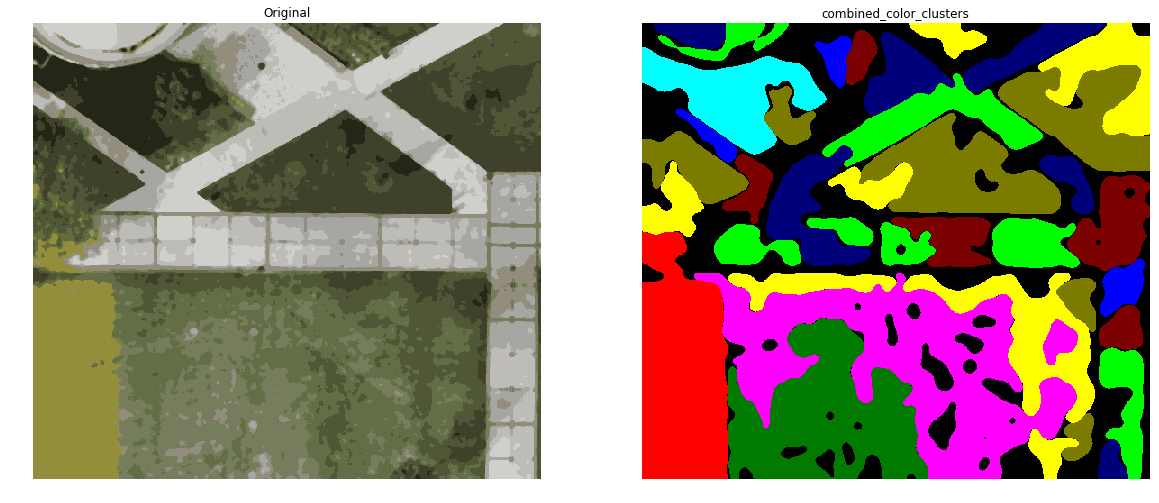

In [254]:
# stack all colors together and compare to original image to visualize regions

combined_color_clusters = np.zeros((HEIGHT, WIDTH, 3))

for i in range(0, NUM_CLUSTERS):
    mask = colored_clusters[i] != 0 # != 0 means its color
    combined_color_clusters[mask] = colored_clusters[i][mask]

combined_color_clusters = combined_color_clusters.astype(np.uint8)

image_list = [IMAGE, combined_color_clusters]
title_list = ['Original', 'combined_color_clusters']
plot_images(image_list, title_list)

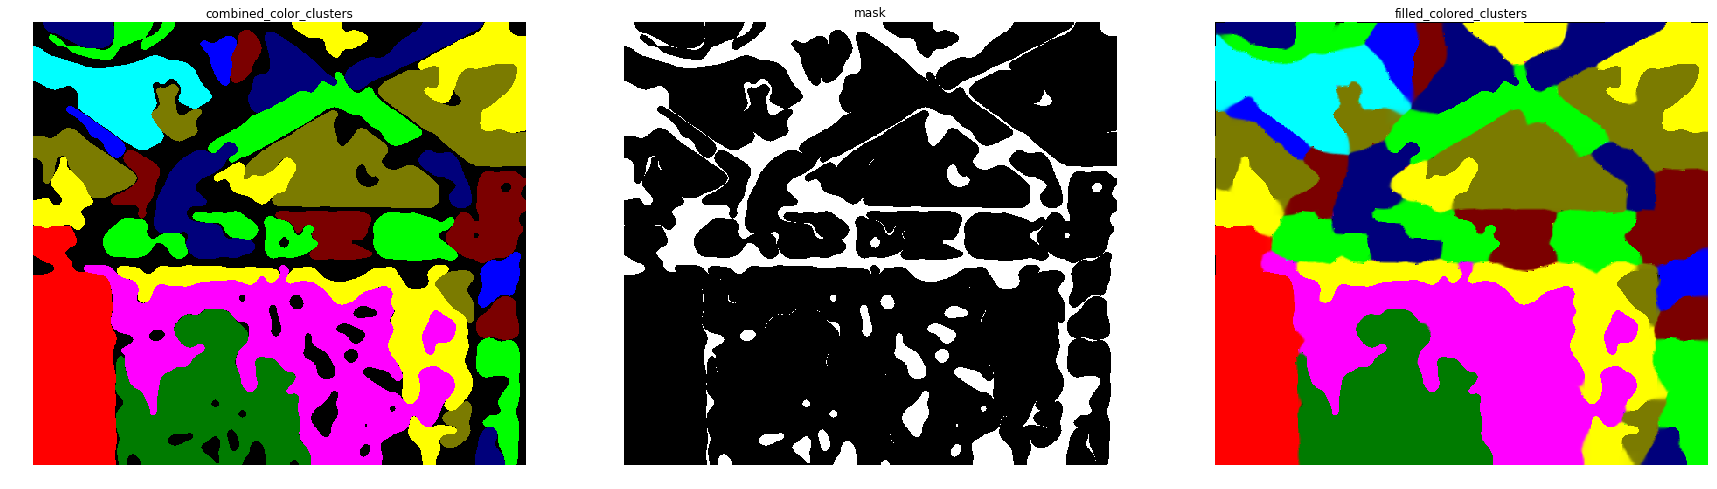

In [256]:
# encroach on black area

mask = np.all(combined_color_clusters == 0, axis=(2)).astype(np.uint8) # paint nonzero pixels
filled_colored_clusters = cv2.inpaint(combined_color_clusters, mask, 3, cv2.INPAINT_NS) # cv2.INPAINT_NS

plot_images([combined_color_clusters, (mask*255), filled_colored_clusters], ['combined_color_clusters', 'mask', 'filled_colored_clusters'])

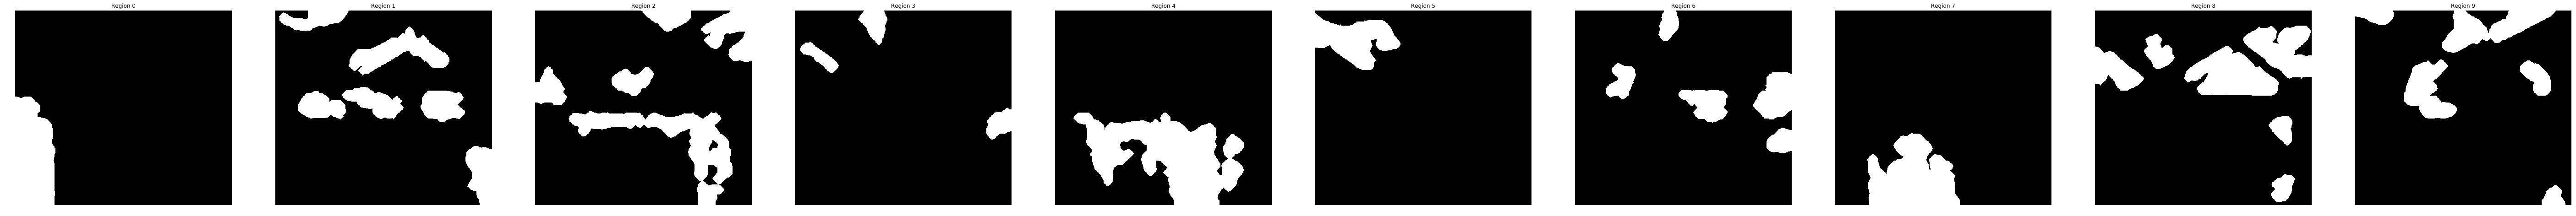

In [257]:
# regions are now expanded to fit gaps, issue with fuzzy border

filled_clusters = []

for i in range(0, NUM_CLUSTERS):
    mask = filled_colored_clusters == colors[i]
    mask = mask.astype(np.uint8)*255
    mask = cv2.bitwise_and(cv2.bitwise_and(mask[:, :, 0], mask[:, :, 1]), mask[:, :, 2])
    mask = cv2.dilate(mask, disk(radius=2), iterations=4)
    filled_clusters.append(mask)

plot_images(filled_clusters, ['Region '+str(i) for i in range(0, NUM_CLUSTERS)])

match: [0, 2, 4, 5, 7, 8]
match: [1, 3, 6, 9]


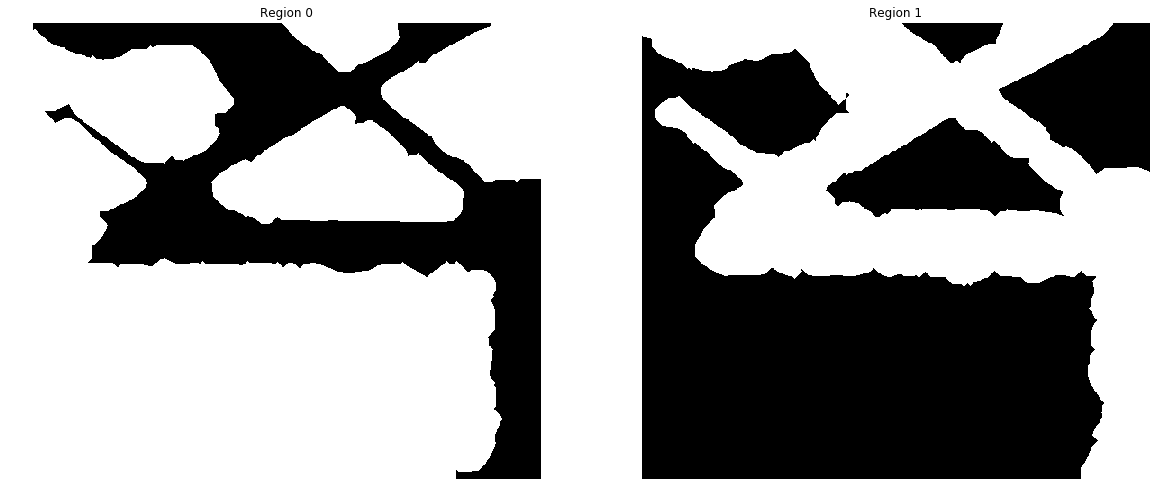

In [258]:
# match similar regions
matched = [[0, 2, 4, 5, 7, 8], [1, 3, 6, 9]]

matched_regions = []
for match in matched:
    print('match:', match)
    matched = np.zeros((HEIGHT, WIDTH)).astype(np.uint8)
    for region_number in match:
        matched = cv2.bitwise_or(matched, filled_clusters[region_number])
    
    matched_regions.append(matched.astype(np.uint8))

plot_images(matched_regions, ['Region '+str(i) for i in range(0, len(matched))])

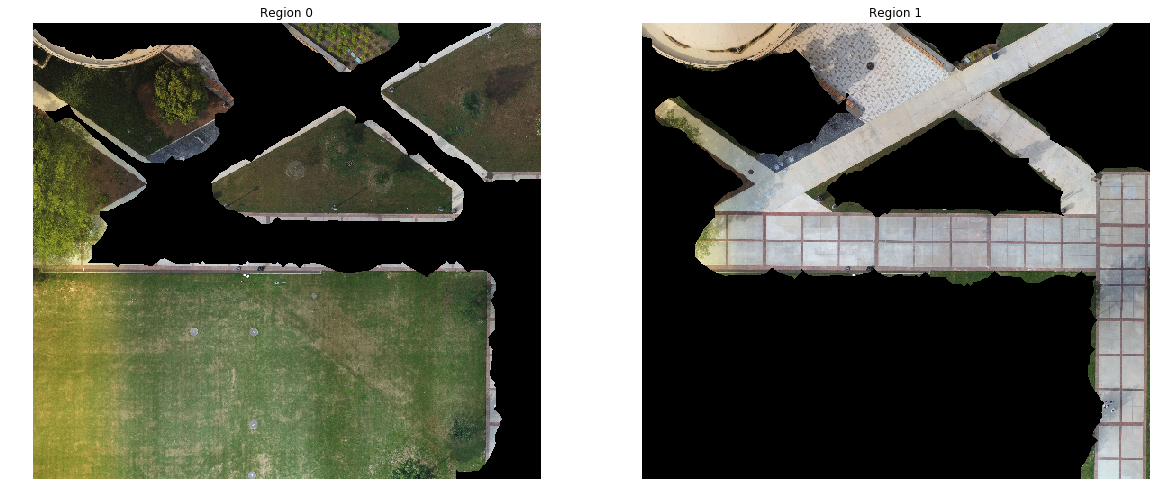

In [262]:
final_regions = []
for i in range(0, len(matched_regions)):
    final_region = cv2.bitwise_and(image_bgr, image_bgr, mask=matched_regions[i])
    final_regions.append(final_region.astype(np.uint8))

plot_images(final_regions, ['Region '+str(i) for i in range(0, len(matched_regions))])

# Histogram

255


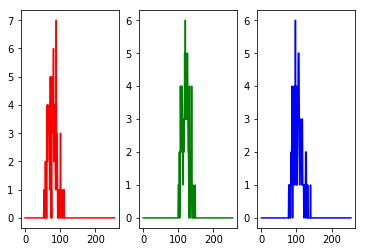

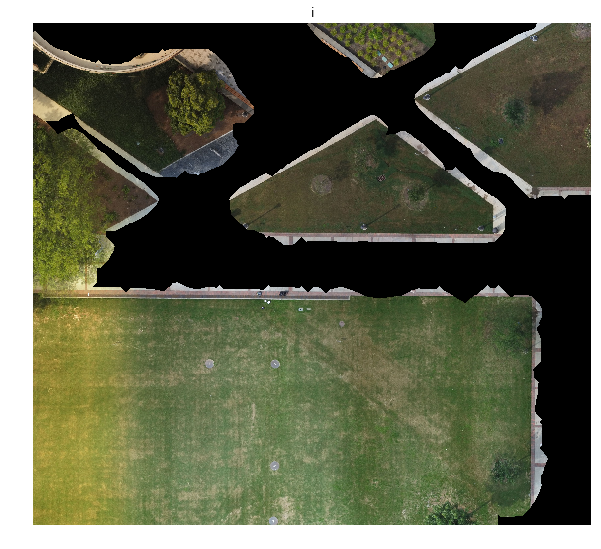

In [277]:
print(np.max(matched_regions))

i = 0
a = cv2.calcHist(final_regions[i][400:500, 100:200, 0], [0], None, [256], [0, 256])
b = cv2.calcHist(final_regions[i][400:500, 100:200, 1], [0], None, [256], [0, 256])
c = cv2.calcHist(final_regions[i][400:500, 100:200, 2], [0], None, [256], [0, 256])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(a, 'r')
ax2.plot(b, 'g')
ax3.plot(c, 'b')

plot_images([final_regions[i]], ['i'])

# Simpler Method...

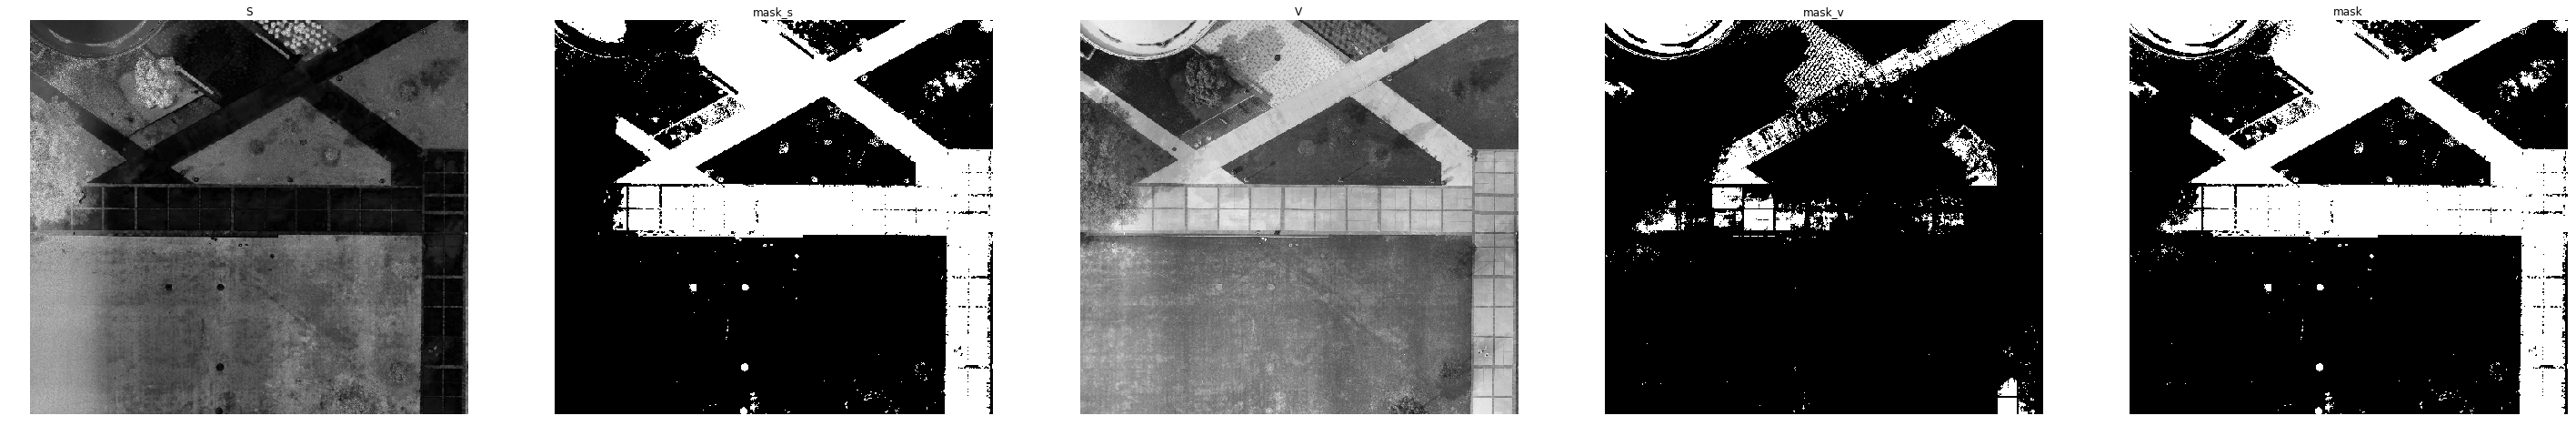

In [53]:
mask_s = (original_image_hsv[:, :, 1] < 50).astype(np.uint8)*255
mask_v = (original_image_hsv[:, :, 2] > 200).astype(np.uint8)*255
mask = cv2.bitwise_or(mask_s, mask_v)

image_list = [original_image_hsv[:, :, 1], mask_s, original_image_hsv[:, :, 2], mask_v, mask]
title_list = ['S', 'mask_s', 'V', 'mask_v', 'mask']
plot_images(image_list, title_list)

In [21]:
# lower_blue_shadow = np.array([50, 50, 50]) #HSV
# upper_blue_shadow = np.array([175, 255, 255])
# mask = cv2.inRange(original_image_hsv, lower_blue_shadow, upper_blue_shadow)
# shadow_image = cv2.bitwise_and(mask, mask)

# lower_green_tree = np.array([25, 50, 50]) #HSV
# upper_green_tree = np.array([100, 255, 255])
# mask = cv2.inRange(original_image_hsv, lower_green_tree, upper_green_tree)
# tree_image = cv2.bitwise_and(mask, mask)

# image_list = [original_image_hsv, shadow_image, tree_image]
# title_list = ['HSV', 'Shadow', 'Tree']
# plot_images(image_list, title_list)

In [22]:
# s = cv2.calcHist(original_image_hsv[:, :, 1], [0], None, [256], [0, 256])
# plt.plot(s, 'b')


# mask = original_image_hsv[:, :, 1] > 150
# mask = mask.astype(np.uint8)*255

# image_list = [original_image_hsv[:, :, 1], mask]
# title_list = ['S', 'S mask']
# plot_images(image_list, title_list)

In [23]:
# edges = cv2.Canny(cv2.cvtColor(smooth_image, cv2.COLOR_BGR2GRAY), 100, 200)

# smooth_image_lines = copy.deepcopy(smooth_image)
# smooth_image_circles = copy.deepcopy(smooth_image)

# lines = cv2.HoughLines(edges, 1, np.pi/180, 80)
# if lines is not None:
#     print('Number of lines:', lines.shape[0])
#     for line in lines:
#         rho = line[0][0]
#         theta = line[0][1]
#         a = np.cos(theta)
#         b = np.sin(theta)
#         x0 = a*rho
#         y0 = b*rho
#         x1 = int(x0 + 1000*(-b))
#         y1 = int(y0 + 1011*(a))
#         x2 = int(x0 - 1000*(-b))
#         y2 = int(y0 - 1000*(a))

#         cv2.line(smooth_image_lines, (x1,y1), (x2,y2), (0, 0, 255), 2)
    
# circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=100)
# if circles is not None:
#     circles = np.uint16(np.around(circles))
#     print('Number of circles:', circles.shape[1])

#     for circle in circles[0, :]:
#         center = (circle[0], circle[1])
#         cv2.circle(smooth_image_circles, center, 1, (255, 0, 255), 2)
#         radius = circle[2]
#         cv2.circle(smooth_image_circles, center, radius, (0, 255, 0), 1)

# image_list = [smooth_image, edges, smooth_image_lines, smooth_image_circles]
# title_list = ['Smooth', 'Edges', 'Lines', 'Circles']
# plot_images(image_list, title_list)